In [1]:
import mlflow
import mlflow.spacy
import mlflow.sklearn
import polars as pl
import seaborn as sns
import scipy
import duckdb
import numpy as np
import json
import timeit
import matplotlib.pyplot as plt
from rank_bm25 import BM25Okapi

In [2]:
import os
import sys
from dotenv import load_dotenv
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))
from app.model_functions import run_BOW_on_line
from app.evaluation import reciprocal_rank, rank_BOW_results, precision_at_k
from app.data_handling.BOW import transform_ds_to_BOW
from app.data_handling.NER_parquet import (
process_ingredient,
transform_ingredients_to_tokens,
transform_data_to_tokens,
construct_ingredient_query,
ParquetDefinition,
create_parquet_file
)

load_dotenv()

True

In [3]:
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URL"))

In [4]:
with open("../../data/eval_data/processed_data.json", "r") as f:
    query_ds = pl.read_json(f)

In [5]:
with open("../../data/eval_data/human_annotations.json", "r") as f:
    human_query_ds = pl.read_json(f)

In [6]:
#query_ds = query_ds.slice(0,3)

In [7]:
with open("../../data/eval_data/eval_10k.json", "r") as f:
    eval_ds = pl.read_json(f)

In [8]:
#eval_ds = query_ds

### Sanitycheck that query_ds is a subset of eval_ds

In [9]:
query_idx = query_ds['index']
eval_ds.select('index').filter(pl.col('index').is_in(query_idx)).shape[0] == query_ds.shape[0]

/tmp/ipykernel_725100/3215214846.py:2: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  eval_ds.select('index').filter(pl.col('index').is_in(query_idx)).shape[0] == query_ds.shape[0]


True

In [10]:
model_uri = 'models:/recipe_BOW@prod'
BOW_model = mlflow.sklearn.load_model(model_uri)

/home/naabzer/develop/recipe_tm/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
results_df = pl.DataFrame(
    schema={
        'Model': pl.String,
        'Eval_Task': pl.String,
        "MRR": pl.Float64,
        "P@3": pl.Float64,
        "Time_Tot": pl.Float64,
        "Time_Query": pl.Float64,
        "Error_Count": pl.Int32
    })

In [12]:
results_df

Model,Eval_Task,MRR,P@3,Time_Tot,Time_Query,Error_Count
str,str,f64,f64,f64,f64,i32


# BOW Evaluation 

In [13]:
start = timeit.default_timer()
eval_ds_title = transform_ds_to_BOW(eval_ds, BOW_model, use_title=True)
time = timeit.default_timer() - start
print(f"Dataset transformation took {time}s, or {time/eval_ds.shape[0]}s/row")

Dataset transformation took 76.30874224903528s, or 0.007630874224903527s/row


In [14]:
start = timeit.default_timer()
eval_ds = transform_ds_to_BOW(eval_ds, BOW_model)
time = timeit.default_timer() - start
print(f"Dataset transformation took {time}s, or {time/eval_ds.shape[0]}s/row")

Dataset transformation took 80.42974065098679s, or 0.00804297406509868s/row


In [15]:
eval_ds.head()

,title,ingredients,directions,link,source,NER,index,tfidf
i64,str,list[str],list[str],str,str,str,i64,object
493,"""Sour Cream Meat Loaf""","[""2 lb. ground lean beef"", ""1 1/2 c. grated raw carrot"", … ""2 c. sour cream""]","[""Combine all ingredients in large mixing bowl; blend well. Pack in a 9 x 5 x 3-inch loaf pan."", ""Bake at 350° for 1 1/2 to 1 3/4 hours."", ""Serves 6.""]","""www.cookbooks.com/Recipe-Detai…","""Gathered""","""[""ground lean beef"", ""carrot"",…",493,"<Compressed Sparse Row sparse matrix of dtype 'float64' with 28 stored elements and shape (1, 126980)> Coords Values (0, 8487) 0.14346478229108336 (0, 10736) 0.15177545563464329 (0, 12865) 0.1449682210765886 (0, 13054) 0.13475418049953153 (0, 22880) 0.14495922304075423 (0, 28368) 0.12319760287266307 (0, 31532) 0.108961581268099 (0, 32325) 0.16632155031239737 (0, 37757) 0.12192601318498932 (0, 38785) 0.10661744382970542 (0, 45787) 0.17746439580483983 (0, 49909) 0.39519992435246926 (0, 50637) 0.11423542534916412 (0, 65634) 0.11652116480855519 (0, 65708) 0.18018226610650634 (0, 77476) 0.14549797982263138 (0, 80239) 0.1580197976104843 (0, 81454) 0.10441312071103709 (0, 86763) 0.09794236895590921 (0, 90665) 0.13543784221336122 (0, 93108) 0.17285248700353686 (0, 94385) 0.3606351126352355 (0, 99135) 0.09397730342258986 (0, 105058) 0.1096875601624115 (0, 106873) 0.14207617769931047 (0, 109846) 0.29999192401053854 (0, 117669) 0.36819145936146314 (0, 119207) 0.23865509431272386"
1244,"""Chocolate Pistachio Cake""","[""1 box Duncan Hines yellow cake mix"", ""1 box instant pistachio pudding"", … ""1/2 can Hershey's chocolate syrup""]","[""Blend to moisten, then beat for 2 minutes."", ""(Optional: a few drops of green food dye for a richer green color.) Pour about 3/4 batter into a greased and floured Bundt pan."", … ""When cool, dust with confectioners sugar.""]","""www.cookbooks.com/Recipe-Detai…","""Gathered""","""[""orange juice"", ""water"", ""oil…",1244,"<Compressed Sparse Row sparse matrix of dtype 'float64' with 20 stored elements and shape (1, 126980)> Coords Values (0, 17075) 0.3864465474907311 (0, 20473) 0.1691309873317001 (0, 26563) 0.16127134622284733 (0, 38037) 0.2827719087284291 (0, 38248) 0.3672231917437459 (0, 38785) 0.1324222937359522 (0, 44266) 0.2216935427958029 (0, 50135) 0.15252699290595975 (0, 53449) 0.2657412184910988 (0, 53762) 0.28335850761727677 (0, 56548) 0.20151771125137108 (0, 59255) 0.148878253144173 (0, 74931) 0.17376891772544997 (0, 80910) 0.13399871280472578 (0, 81796) 0.17337496821823634 (0, 88833) 0.25118494650515605 (0, 92244) 0.20050120200114005 (0, 111570) 0.19599027674835204 (0, 122445) 0.14368800634998474 (0, 125188) 0.19244883710438307"
1292,"""Corn Pudding""","[""1 can golden crushed corn"", ""2 eggs, slightly beaten"", … ""sprinkle of paprika""]","[""Melt butter in casserole."", ""Beat eggs."", … ""Bake at 325° for an hour (it should jiggle and a knife should come out kinda clean).""]","""www.cookbooks.com/Recipe-Detai…","""Gathered""","""[""golden crushed corn"", ""eggs""…",1292,"<Compressed Sparse Row sparse matrix of dtype 'float64' with 17 stored elements and shape (1, 126980)> Coords Values (0, 12865) 0.20926381155820706 (0, 19799) 0.15156933551890595 (0, 30536) 0.20179801433591918 (0, 32419) 0.20141762975584895 (0, 38785) 0.15390388671879968 (0, 43898) 0.15822177620926767 (0, 48889) 0.27410644289732805 (0, 51767) 0.44724791879648534 (0, 68010) 0.35608179768719606 (0, 84767) 0.23404094232123773 (0, 86763) 0.1413812854192753 (0, 99135) 0.13565765357487183 (0, 105137) 0.2693582531771503 (0, 108043) 0.2926530743832155 (0, 109075) 0.20410156880278726 (0, 110260) 0.13918430446890578 (0, 113237) 0.298107071621375"
1461,"""Apricot Cake""","[""2 c. sugar"", ""4 eggs"", … ""1/2 c. chopped nuts (English or pecans)""]","[""Mix together sugar, eggs, oil and baby food."", ""Add flour, baking soda, salt, cinnamon and nuts; bake at 350° for 1 hour and 20 minutes."", ""Make sure cake is completely cooled before frosting it.""]","""www

In [16]:
# Run once to download model, to put that time into the time measurement
emb_query = run_BOW_on_line("pecans", model_uri)

In [17]:
def evaluation_task_BOW(eval_ds: pl.DataFrame, query_ds: pl.DataFrame, query_field: str, results_df: pl.DataFrame,
                        task_name: str, use_title: bool = False, model_name: str = "bow"):
    tot_rr = 0
    tot_prec_at_3 = 0
    tot_evals = 0
    errors = 0
    start = timeit.default_timer()
    for index, title, q in query_ds.select('index', 'title', query_field).iter_rows():
        query = ""
        if use_title:
            query += title + " "
        if query_field == 'google_search_query_processed':
            query += "\n".join(q['ingredients'])
        else:
            query += "\n".join(q)
        emb_query = run_BOW_on_line(query, model_uri)
        ranked_ds = rank_BOW_results(eval_ds, emb_query)
        tot_rr += reciprocal_rank(ranked_ds, index)
        tot_prec_at_3 += precision_at_k(ranked_ds, index)
        tot_evals += 1
    time = timeit.default_timer() - start
    mrr = tot_rr/tot_evals
    mprec3 = tot_prec_at_3 / tot_evals
    result_data = {
        "Model": [model_name],
        'Eval_Task': [task_name],
        "MRR": [mrr],
        "P@3": [mprec3],
        "Time_Tot": time,
        "Time_Query": time/tot_evals,
        "Error_Count": errors
    }
    result_df = pl.DataFrame(result_data)
    results_df = results_df.vstack(result_df)
    return results_df

In [18]:
results_df = evaluation_task_BOW(eval_ds, query_ds, 'ingredients', results_df, 'identity')
results_df = evaluation_task_BOW(eval_ds, query_ds, 'main_food_items_and_preparations', results_df, 'llm1')
results_df = evaluation_task_BOW(eval_ds, query_ds, 'important_ingredients_for_search', results_df, 'llm2')
results_df = evaluation_task_BOW(eval_ds, query_ds, 'google_search_query_processed', results_df, 'llm3')

In [19]:
results_df = evaluation_task_BOW(eval_ds, human_query_ds, 'human_ingredients', results_df, 'gold_ingredients')
results_df = evaluation_task_BOW(eval_ds, human_query_ds, 'human_key_ingredients', results_df, 'gold_key_ingredients')

In [20]:
results_df = evaluation_task_BOW(eval_ds_title, query_ds, 'ingredients', results_df, 'identity', use_title=True, model_name='bow_title')
results_df = evaluation_task_BOW(eval_ds_title, query_ds, 'main_food_items_and_preparations', results_df, 'llm1', model_name='bow_title')
results_df = evaluation_task_BOW(eval_ds_title, query_ds, 'important_ingredients_for_search', results_df, 'llm2', model_name='bow_title')
results_df = evaluation_task_BOW(eval_ds_title, query_ds, 'google_search_query_processed', results_df, 'llm3', model_name='bow_title')

In [21]:
results_df = evaluation_task_BOW(eval_ds_title, human_query_ds, 'human_ingredients', results_df, 'gold_ingredients', model_name='bow_title')
results_df = evaluation_task_BOW(eval_ds_title, human_query_ds, 'human_key_ingredients', results_df, 'gold_key_ingredients', model_name='bow_title')

# NER DB 
Currently this should perform pretty bad, since there is no ranking function, the metrics would be pretty random for any result where you have more than a few results after filtering.

In [22]:
model_uri = "models:/recipe_NER@prod"
ner = mlflow.spacy.load_model(model_uri=model_uri)

In [23]:
def rank_results(df: pl.DataFrame, query: list[str]):
    if df.shape[0] == 0:
        return df
    corpus = list(df['tokens'])
    bm25 = BM25Okapi(corpus)
    scores = bm25.get_scores(query)
    ranked_ds = df.with_columns(
        pl.Series(name='rank', values=scores)
    ).sort('rank', descending=True)
    return ranked_ds

### Identity query

In [28]:
pq_filen = "eval_test_10k.parquet"

# start = timeit.default_timer()
tokens, preps, optionals = transform_data_to_tokens(eval_ds['ingredients'], ner)

# inp = [
    ParquetDefinition(data=tokens, name="tokens"),
    ParquetDefinition(data=preps, name="preps", is_map=True),
    ParquetDefinition(data=optionals, name="optionals")
]
create_parquet_file(pq_filen, eval_ds.select(pl.exclude('tfidf')), inp)
time = timeit.default_timer() - start

In [29]:
print(f"Dataset transformation took {time}s, or {time/eval_ds.shape[0]}s/row")

Dataset transformation took 80.42974065098679s, or 0.00804297406509868s/row


In [30]:
def evaluation_task_NER(parquet_path:str, query_ds: pl.DataFrame, query_field: str, results_df: pl.DataFrame, task_name: str, debug = False):
    tot_rr = 0
    tot_prec_at_3 = 0
    tot_evals = 0
    errors = 0
    start = timeit.default_timer()
    for index, query in query_ds.select('index', query_field).iter_rows():
        if query_field == 'google_search_query_processed':
            query_obj = transform_ingredients_to_tokens(query['ingredients'], ner)
        else:
            query_obj = transform_ingredients_to_tokens(query, ner)
        sql = construct_ingredient_query(parquet_path, query_obj['foods'], query_obj['preps'])
        try:
            results = duckdb.sql(sql).pl()
            if debug and results.shape[0] == 0:
                print(sql)
                print("-- Zero results --")
                print(index)
                print("- Target -")
                t = duckdb.sql(f"SELECT preps, tokens FROM '{parquet_path}' WHERE index == {index}").pl()
                print(list(t[0, 1]))
                print(list(t[0, 0]))
                #print(" ".join(list(t[0])))
                print("- Query -")
                print(" ".join(query_obj['foods']))
                print(query_obj['preps'])
            results = rank_results(results, query_obj['foods'])
            tot_rr += reciprocal_rank(results, index)
            tot_prec_at_3 += precision_at_k(results, index)
            tot_evals += 1
        except Exception as e:
            errors += 1
            print(e)
            continue
    time = timeit.default_timer() - start
    mrr = tot_rr/tot_evals
    mprec3 = tot_prec_at_3 / tot_evals
    result_data = {
        "Model": ['ner'],
        'Eval_Task': [task_name],
        "MRR": [mrr],
        "P@3": [mprec3],
        "Time_Tot": time,
        "Time_Query": time/tot_evals,
        "Error_Count": errors
    }
    result_df = pl.DataFrame(result_data)
    results_df = results_df.vstack(result_df)
    return results_df

In [31]:
results_df = evaluation_task_NER(pq_filen, query_ds, 'ingredients', results_df, 'identity')
results_df = evaluation_task_NER(pq_filen, query_ds, 'main_food_items_and_preparations', results_df, 'llm1')
results_df = evaluation_task_NER(pq_filen, query_ds, 'important_ingredients_for_search', results_df, 'llm2')
results_df = evaluation_task_NER(pq_filen, query_ds, 'google_search_query_processed', results_df, 'llm3')

Binder Error: Referenced column "piment_d'espelette" not found in FROM clause!
Candidate bindings: "index", "preps", "ingredients", "optionals", "tokens"
Binder Error: Referenced column "'" not found in FROM clause!
Candidate bindings: "C0"
Binder Error: Referenced column "campbell_'s_condense" not found in FROM clause!
Candidate bindings: "preps"
Binder Error: Referenced column "bottlefrank_'s" not found in FROM clause!
Candidate bindings: "title", "optionals", "tokens", "directions", "ingredients"
Binder Error: Referenced column "'" not found in FROM clause!
Candidate bindings: "C0"
Binder Error: Referenced column "piment_d'espelette" not found in FROM clause!
Candidate bindings: "index", "preps", "ingredients", "optionals", "tokens"
Binder Error: Referenced column "'" not found in FROM clause!
Candidate bindings: "C0"
Binder Error: Referenced column "'" not found in FROM clause!
Candidate bindings: "C0"
Binder Error: Referenced column "'" not found in FROM clause!
Candidate bindings

In [32]:
results_df = evaluation_task_NER(pq_filen, human_query_ds, 'human_ingredients', results_df, 'gold_ingredients')
results_df = evaluation_task_NER(pq_filen, human_query_ds, 'human_key_ingredients', results_df, 'gold_key_ingredients')

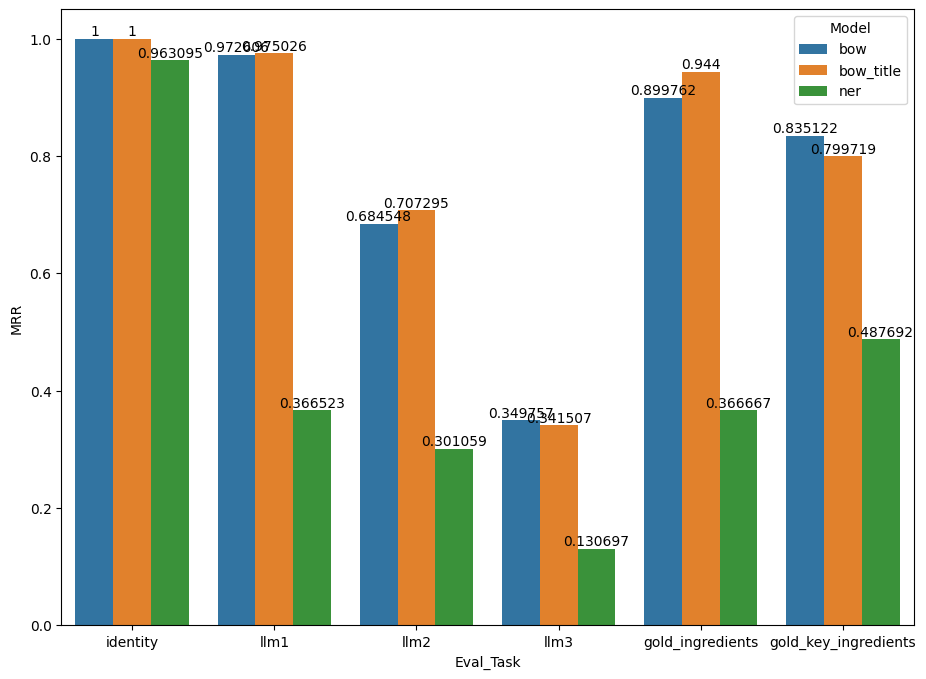

In [33]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='MRR', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

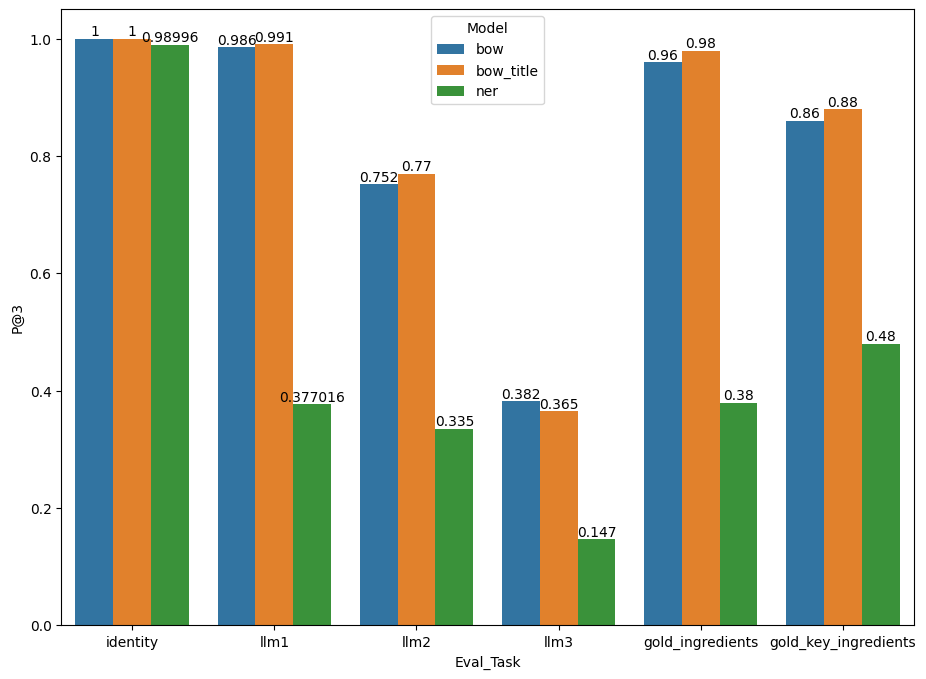

In [34]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='P@3', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

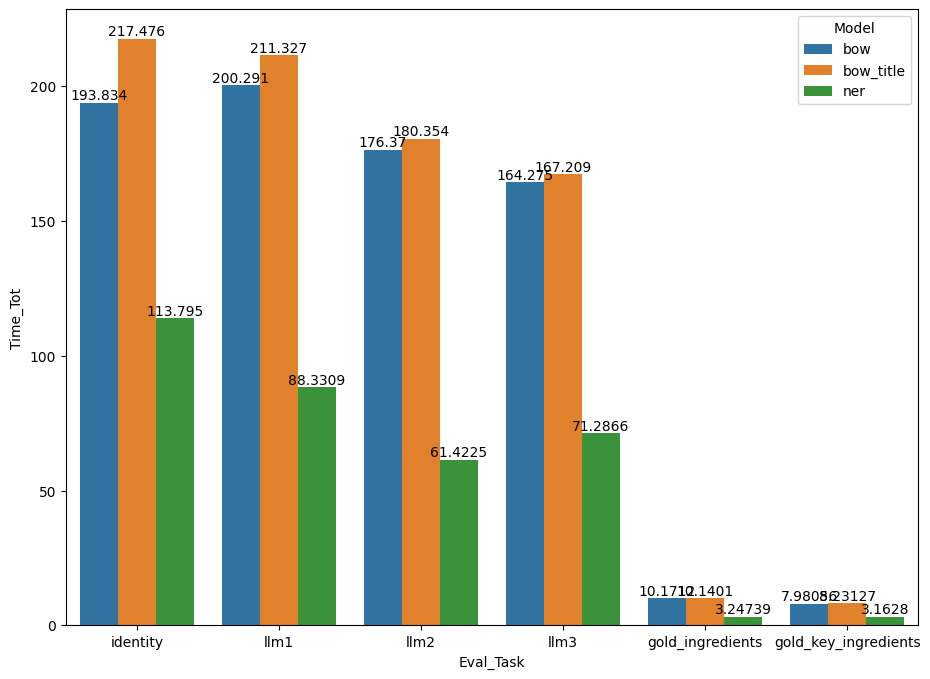

In [35]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='Time_Tot', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

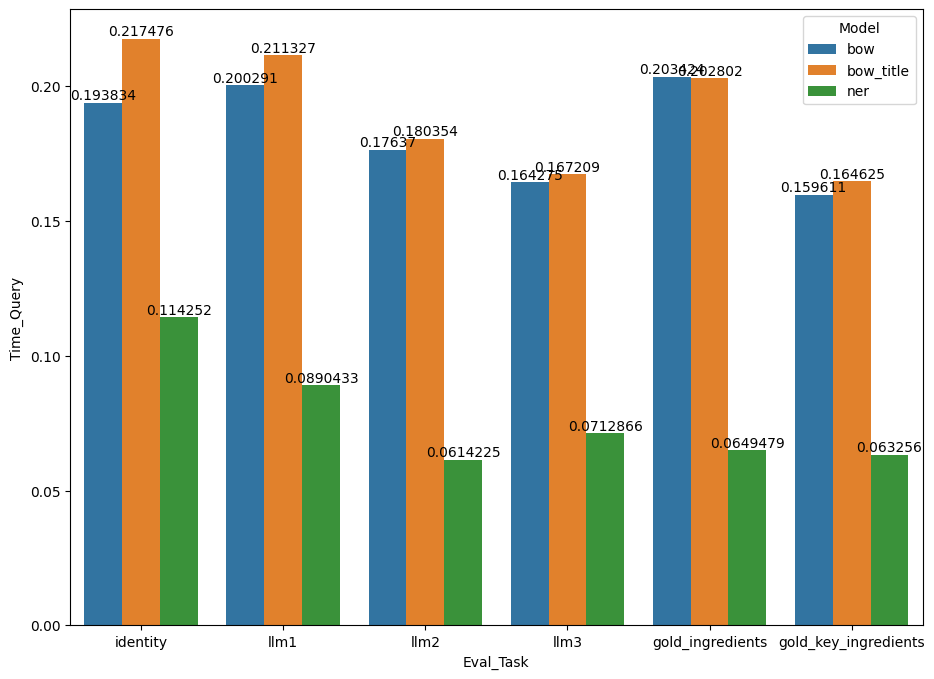

In [36]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='Time_Query', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

In [37]:
results_df

Model,Eval_Task,MRR,P@3,Time_Tot,Time_Query,Error_Count
str,str,f64,f64,f64,f64,i32
"""bow""","""identity""",1.0,1.0,193.83446,0.193834,0
"""bow""","""llm1""",0.972606,0.986,200.290713,0.200291,0
"""bow""","""llm2""",0.684548,0.752,176.370295,0.17637,0
"""bow""","""llm3""",0.349757,0.382,164.274703,0.164275,0
"""bow""","""gold_ingredients""",0.899762,0.96,10.171218,0.203424,0
…,…,…,…,…,…,…
"""ner""","""llm1""",0.366523,0.377016,88.330942,0.089043,8
"""ner""","""llm2""",0.301059,0.335,61.422461,0.061422,0
"""ner""","""llm3""",0.130697,0.147,71.286601,0.071287,0


In [38]:
from datetime import datetime
date_time = datetime.now().strftime("%Y_%m_%d__%H_%M")

In [39]:
date_time

'2025_06_10__22_03'

In [40]:
results_df.write_parquet(f"../../data/results/temp/{date_time}.parquet")

In [41]:
pl.read_parquet(f"../../data/results/temp/{date_time}.parquet")

Model,Eval_Task,MRR,P@3,Time_Tot,Time_Query,Error_Count
str,str,f64,f64,f64,f64,i32
"""bow""","""identity""",1.0,1.0,193.83446,0.193834,0
"""bow""","""llm1""",0.972606,0.986,200.290713,0.200291,0
"""bow""","""llm2""",0.684548,0.752,176.370295,0.17637,0
"""bow""","""llm3""",0.349757,0.382,164.274703,0.164275,0
"""bow""","""gold_ingredients""",0.899762,0.96,10.171218,0.203424,0
…,…,…,…,…,…,…
"""ner""","""llm1""",0.366523,0.377016,88.330942,0.089043,8
"""ner""","""llm2""",0.301059,0.335,61.422461,0.061422,0
"""ner""","""llm3""",0.130697,0.147,71.286601,0.071287,0
